## Exploratory Data Analysis
This notebook explores data structure, uncover distribution patterns, and analyze relationships between key features.

The analysis is structured as follows:
- Dataset Overview
- Summary Statistics
- Visualizing Distributions
- Exploring Relationships

### Import Libraries

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Cleaned Dataset

In [2]:
df = pd.read_csv(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final.csv')

### Dataset Overview
This section provides a high-level look at the cleaned dataset, including dataset size, data types and number of missing values. This helps ensure the dataset is loaded correctly and ready for analysis.

In [3]:
df.shape


(22002, 21)

In [4]:
df.dtypes

job_title_short           object
job_title                 object
job_location              object
job_via                   object
job_schedule_type         object
job_work_from_home          bool
search_location           object
job_posted_date           object
job_no_degree_mention       bool
job_health_insurance        bool
job_country               object
salary_rate               object
company_name              object
job_skills                object
job_type_skills           object
salary_year_avg_eur      float64
salary_month_avg_eur     float64
country                   object
is_eu                       bool
ISO                       object
region_group              object
dtype: object

In [5]:
df.isna().sum()

job_title_short              0
job_title                    0
job_location               280
job_via                      0
job_schedule_type           16
job_work_from_home           0
search_location              0
job_posted_date              0
job_no_degree_mention        0
job_health_insurance         0
job_country                  0
salary_rate                  0
company_name                 0
job_skills                1833
job_type_skills           1833
salary_year_avg_eur          0
salary_month_avg_eur         0
country                  20348
is_eu                        0
ISO                      20348
region_group                 0
dtype: int64

The dataset contains over **22,000 job postings** across **21 columns**, including job titles, locations, salary details, and work conditions. Most columns are categorical, while numerical values are salary values in a monthly format converted to EUR. 

There are no **missing values** in almost all core columns used for analysis, such as job title, salary, and country. However, the job_skills column has around 10% missing values. Since skill-related analysis is a key focus in the final section of this project, we treat this missingness carefully. Rather than dropping these rows entirely (which could remove valuable salary data), we apply targeted filtering and visualization only on the subset where skills are available.

### Summary Statistics
In this section, we explore basic statistics to understand the structure and content of the data. This gives us a foundation for more detailed visual analysis and insights.

#### Numeric column: Monthly salary (EUR)

In [6]:
df['salary_month_avg_eur'].describe().round(0).astype(int)

count    22002
mean      8724
std       3419
min       1061
25%       6368
50%       8137
75%      10614
max      67928
Name: salary_month_avg_eur, dtype: int64

Salary distributions show a wide range. Median salary (~€8,137) is more representative than the mean, and future analysis should segment by role and carefully handling outliers.

#### Categorical counts: Job Title

In [7]:
df['job_title_short'].value_counts().head(5)

job_title_short
Data Scientist           5922
Data Analyst             5450
Data Engineer            4500
Senior Data Scientist    1690
Senior Data Engineer     1591
Name: count, dtype: int64

An initial scan reveals that the top three **most popular data roles** are **Data Scientist**, **Data Analyst**, and **Data Engineer**. These roles stand out with significantly more job postings compared to others, making them the clear **focus for further analysis**.

### Visualizing Distributions

To understand the central tendencies and spread of salaries in our dataset, we start by plotting the overall salary distribution.

#### Salary Distribution

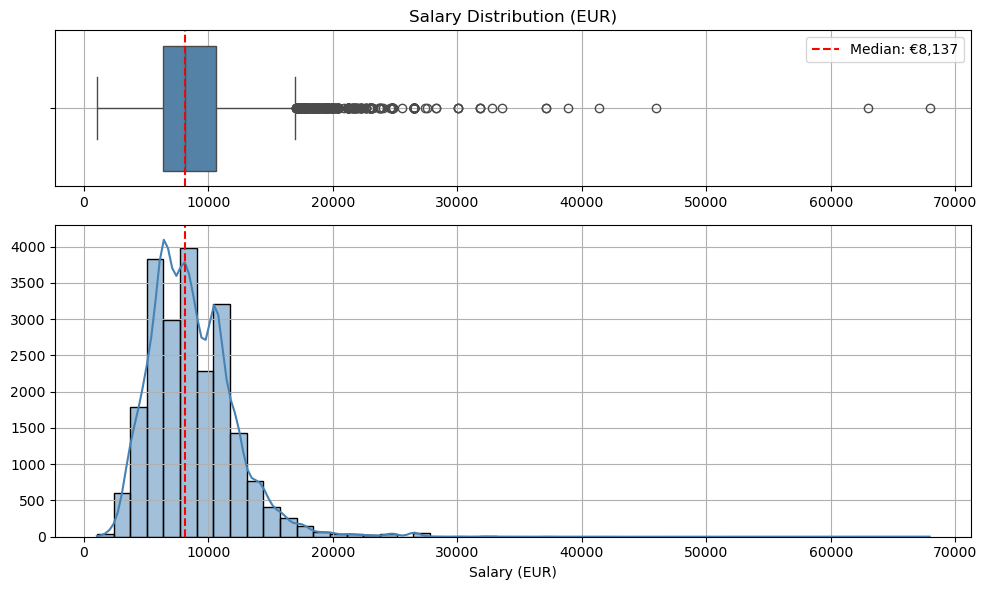

In [8]:
data = df['salary_month_avg_eur'].dropna()
median_salary = data.median()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# Boxplot
sns.boxplot(x=data, ax=ax1, color='steelblue')
ax1.axvline(median_salary, color='red', linestyle='--', label=f'Median: €{median_salary:,.0f}')
ax1.set_title('Salary Distribution (EUR)')
ax1.set_xlabel('')
ax1.grid(True)
ax1.legend()

# Histogram
sns.histplot(data, bins=50, kde=True, ax=ax2, color='steelblue', edgecolor='black')
ax2.axvline(median_salary, color='red', linestyle='--', label=f'Median: €{median_salary:,.0f}')
ax2.set_xlabel('Salary (EUR)')
ax2.set_ylabel('')
ax2.grid(True)

plt.tight_layout()
plt.show()

The salary distribution is right-skewed with significant outliers, suggesting a few exceptionally high-paying roles, that may reflect different job types or experience levels. To explore this deeply let's take a look into meadian salaries by country.

In [9]:
df = df.dropna(subset=['salary_month_avg_eur'])

country_salary_stats = (
    df.groupby('job_country')
    .agg(job_count=('salary_month_avg_eur', 'count'),
         median_salary=('salary_month_avg_eur', 'median'))
         .sort_values(by='median_salary', ascending=False)
         ).round(0).astype(int)

country_salary_stats.head(5)

,job_count,median_salary
job_country,,
Belarus,1,28303
Russia,4,21228
Bahamas,21,14726
Dominican Republic,1,11144
Northern Mariana Islands,1,11002


Some countries—like Belarus, Dominican Republic, and Northern Mariana Islands report **unusually high median salaries**. 

Exploring the cases we can see that they have very small sample sizes. Probably, job postings list a company’s legal registration address rather than the actual work location or listed salaries in local curancies. To correct this, **salary outliers** will be removed for salary analysis based on **job title** and **country**, and for countries with **fewer than 5 postings**, filtering wiil be done using **job title only** to preserve analytical validity.

#### Binary variable distribution

We also want to explore how job descriptions reflect expectations around work flexibility and education. By analyzing the presence (or absence) of remote work options and degree requirements, we can assess how common these attributes are in real-world postings.

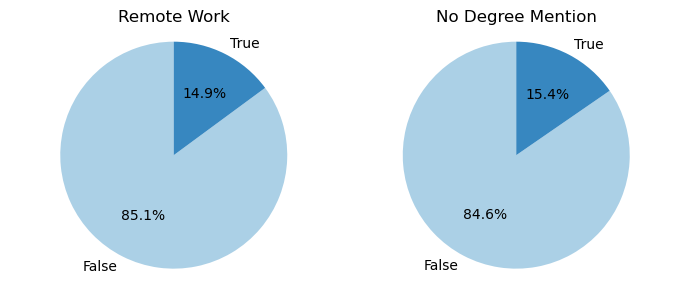

In [10]:
remote_counts = df['job_work_from_home'].value_counts()
degree_counts = df['job_no_degree_mention'].value_counts()

shared_colors = sns.color_palette("Blues", n_colors=2)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Remote Work Pie Chart
axes[0].pie(
    remote_counts,
    labels=remote_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=shared_colors
)
axes[0].set_title('Remote Work')
axes[0].axis('equal')

# No Degree Mention Pie Chart
axes[1].pie(
    degree_counts,
    labels=degree_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=shared_colors
)
axes[1].set_title('No Degree Mention')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

The majority of job postings do not mention remote work options (85%) or the absence of degree requirements (85%). This suggests that while the data industry is often seen as flexible and skills-driven, traditional expectations like on-site presence and formal education still dominate job descriptions. So, we’ll explore how these factors affect salary in the following sections.

### Exploring Relationships

To analyse relationships properly we focus on **Data Analyst** roles, so we can uncover patterns and trends specific to this job title  without the noise from other roles. 

#### Filter the Dataset to Data Analyst

In [11]:
df_da = df[(df['job_title_short'] == 'Data Analyst')].copy()

#### Correlation matrix
To investigate how time affects salary and hiring trends, we focus on the **Data Analyst** role and examine monthly changes in job count and compensation. This helps us understand seasonality in hiring and salary dynamics.

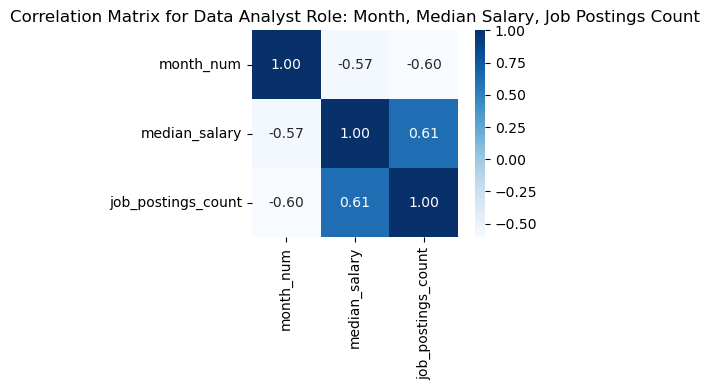

In [12]:
df_da['job_posted_date'] = pd.to_datetime(df_da['job_posted_date'])
df_da['month_num'] = df_da['job_posted_date'].dt.month

# Group by month to get median salary and job count
monthly_stats = df_da.groupby('month_num').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    job_postings_count=('salary_month_avg_eur', 'count')  # or 'size' if column doesn't matter
).reset_index()

# Correlation matrix
correlation_matrix = monthly_stats.corr(numeric_only=True)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Blues', square=True)
plt.title('Correlation Matrix for Data Analyst Role: Month, Median Salary, Job Postings Count')
plt.tight_layout()
plt.show()

**Strong Negative Correlation Between Month and Number of Job Postings (−0.60)**
There is a clear downward trend in job postings as the year progresses. This suggests that more positions are typically available earlier in the year, with fewer opportunities later on (depending on how months are numbered). This pattern likely reflects hiring cycles, budget timelines, or seasonal fluctuations in the job market. A deeper analysis could help identify the best time of year to actively search for a job.

**Strong Positive Correlation Between Monthly Salary and Number of Job Postings (0.61)**
An increase in the number of job postings is also associated with higher salaries. This indicates that during peak hiring periods, companies may offer more competitive compensation. Identifying these peak months can help job seekers maximize their salary potential when entering the job market.

### Median salary by number of skills

Next, we examine how the number of required skills correlates with salary. The hypothesis is that jobs listing more required skills may also offer higher compensation, reflecting higher expectations and complexity.

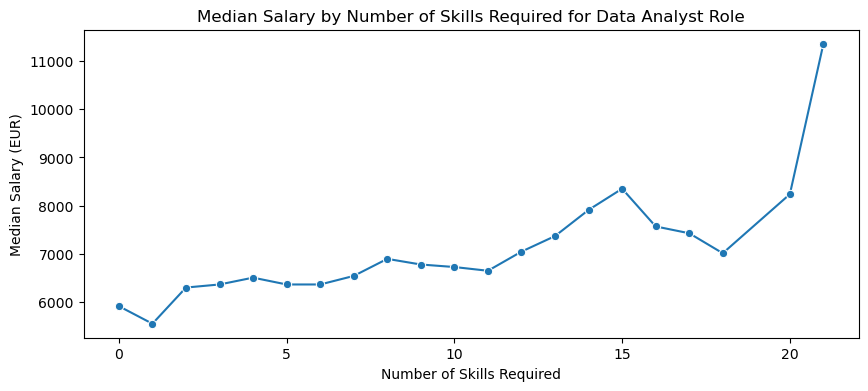

In [13]:
# Count skills function
def count_skills(skills_str):
    if pd.isna(skills_str) or skills_str.strip() == '':
        return 0
    return len([s for s in skills_str.split(',') if s.strip() != ''])

df_da['skills_count'] = df_da['job_skills'].apply(count_skills)

# Median salary by skills count
median_salary_by_skills = df_da.groupby('skills_count')['salary_month_avg_eur'].median().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='skills_count', y='salary_month_avg_eur', data=median_salary_by_skills, marker='o')
plt.title('Median Salary by Number of Skills Required for Data Analyst Role')
plt.xlabel('Number of Skills Required')
plt.ylabel('Median Salary (EUR)')
plt.show()

This chart reveals a **clear positive relationship** between the number of required **skills** and the **median salary**. This means that job seekers aiming for a **Data Analyst** role can potentially increase their compensation by acquiring and posting more relevant skills on their CV. We will explore this insight further in the next steps of the analysis.

### Summary
The exploratory data analysis revealed that the dataset is generally well-structured, salary data shows high variability and right skewness, emphasizing the importance of outlier handling in further analysis.

A clear seasonal pattern emerged: **job postings tend to decrease throughout the year**, while months with **more postings** are associated with **higher median salaries**. 

Additionally, roles requiring a **broader skill set** tend to offer **better compensation**, suggesting that technical versatility is valued in the data job market and can be a key driver of salary.

These insights confirm that salary varies by season and skill breadth, particularly for **Data Analysts**. Next, we explore which roles are most in demand and how skill expectations differ.